In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


## Lagranto and other stuff demo collection
- Collection of codes, notebooks, etc. to do stuff with Lagranto
- Descriptions will be more forthcoming...

**In this notebook** we provide a short demonstration of how to fetch and plot some data using the *py-netcdf4* interface. The first example is taken principally from:
https://geos5.org/wiki/index.php?title=Recipe:_Python_program_as_OPeNDAP_client

Noting that they are still, quite irresponsibly, publishing Python 2.x codes, and also include a small error in the URL of their data (see comment/correction below).

Note, older version(s) of Lagranto should be readily available in PyPy; a simple,

        $ pip install Lagranto
        
should gety you `v1.3` of `v1.7` or so. There is also a download vor `v1.7` somewhere. At this time the current version (appears to) be `v2.0`, and can be downloaded or cloned from the GitLab site:j

    https://git.iac.ethz.ch/atmosdyn/Lagranto

Apparently, they have been having issues with SPAMmers, so it may be necessary to contact the developer to get an account; he is pretty responsive to real humans. Even without the clone, you can download the code form that site, or this link:

    https://git.iac.ethz.ch/atmosdyn/Lagranto/-/archive/master/Lagranto-master.tar.gz

Options for `.zip`, `.tar`, and `.tar.bz2` are also available.

### Installing Lagranto on Sherlock
Installing Lagranto on Sherlock, or likely any HPC (or shared) system -- in general, will probably be more complicated. As it happens, many of these complications are likely to be encountered even for personal workstation installations, so these concepts may be good SOP over a broad domain of users.

Basically, Lagranto seems to suffer from `numpy` version sensitivity. There are many components, and some of them may have an accompanying version of `numpy` or may be coded to a specific version of `numpy`. Lagranto appears to prefer `numpy v16.2`, though it is probably worth putting in a bit more research to see that we are using the correct version of Lagranto as well. In any case, all versions of Lagranto appear to be `numpy`-sensitive, so it is a good use-case for virtual environments.

#### Options for Virtual Environments:
    - `virtualenv`: The standard, stock virtual environments for Python
    - `pipenv`: A pip-integrated implementation of `virtualenv`
        - `direnv`: See also `direnv`, direnv.net , a slick little wrapper that automagically activates an environment when you enter a directory.d
    - `virtualenvwrapper`: A wrapper around `virtualenv` with some more user-friendly syntax
    - `conda`: Of course.

Of these, `conda` is probabyl the most intuitive, but they all have certain areas of friction in HPC or shared computing environments. Sadly, the tradeoof seems to be pretty consistent with "good on my laptop" -> "clumsy and complicated on HPC," and vice versa. In otherwords, on my laptop pretty much everything is `conda`, but in an HPC environment, I'm likely going to go with plain-ole `virtualenv`. 

One example of HPC feriction is that one or more of the more user-friendly wrappers will try to set an environment variable to designate the Python executable path, but this can change or be non-standard, depending on how modules load.

#### My Sherlock installation:
- I chose plain `virtualenv`.
Following the standard directions in the above link, something like this:

        
        $ mkdir -p $SCRATCH/Codes/lagrando_demo
        $ cd $SCRATCH/Codes/lagranto_demo
        $ virtualenv env_lagranto
        

Then, I wrap up the whole executable environment into a `.lua` module script:

        [myoder96@sh01-ln03 login ~]$ cat ~/.local/modulefiles/py-lagranto/0.2.0.lua 
        -- -*- lua -*-
        -- vim:ft=lua:et:ts=4
        --
        -- NOTE: this module hierarchy is not ideal. Sherlock currently defaults to Python2, and
        --   the python packages (py-sss) are not explicitly Python2/3 separated... so if the default version, of say
        --   py-numpy, is a Python2 flavor, then "module load py-numpy" will replace Py3 -> Py2. So we basically have
        --   to hard-code versions, so modules will not naturally upgrade.
        --

        load("python/3")
        load("py-ipython/6.1.0_py36")
        --load("py-numpy/1.17.2_py36")
        --load("viz")
        --load("py-matplotlib/3.1.1_py36")
        --load("py-netcdf4/1.3.1_py36")
        --
        -- physics libraries:
        load("physics")
        load("py-pyproj/1.9.5.1_py36")
        load("geos")
        --
        os.execute("/scratch/users/myoder96/lagranto_demo/env_lagranto/bin/activate")
        --
        -- get module name/version and build paths

        --pkg.name = myModuleName()
        --pkg.version = myModuleVersion()
        --pkg.id = pathJoin(pkg.name, pkg.version)
        --
        ------ module info
        -- whatis("Name:        " .. pkg.name)
        -- whatis("Version:     " .. pkg.version)
        -- whatis("Category:    " .. user, analysis, python simulators")
        -- whatis("URL:         " .. "https://lagranto.readthedocs.io/en/latest/tutorial_lagranto.html")
        -- whatis("Description: " .. "Lagranto - A Library to work with trajectories.")
        --
        -- also see this url: https://git.iac.ethz.ch/atmosdyn/Lagranto
        --  but it might be locked behind a login.
        [myoder96@sh01-ln03 login ~]$ 


#### Comments:
There are a few organizational choices to be made.
    - Keep an environment with a project, or keep all environments in one place... or a bit of both?
        - Both general approaches makes sense. Is this an environment specific to a project, or something more multi-functional -- aka, an environment built around a library or module? One feature of (som eof) the wrappers is that the consolidate environments into one place and provide a syntax like `$ activate my_env`, rather than `$ . my_project_path/my_env/bin/activate`.
        - For this application, I'm leaning a bit towards modifying my current approach to use  consolidated environments, maybe in the `~/.local/venv_environments` folder, or something like that.


In [19]:
import numpy, scipy
import matplotlib, pylab
import datetime as dtm, matplotlib.dates as mpd


In [23]:
#!/usr/bin/env python
 
import sys
import numpy as np
import netCDF4 as nc4
import matplotlib.pyplot as plt
# 
from mpl_toolkits.basemap import Basemap
#
# TODO: make a class or a function or something so we can just pass a data-set URL and make a bunch of plots!
#
# At one point they may have used port 9090 for this, but no longer...
#data_url = 'https://opendap.nccs.nasa.gov:9090/dods/OSSE/G5NR/Ganymed/7km/0.5000_deg/inst/inst01hr_3d_T_Cv'
#res = "0.5000_deg"
res = "0.0625_deg"
# inst30mn_3d_T_Nv
#data_url = 'https://opendap.nccs.nasa.gov/dods/OSSE/G5NR/Ganymed/7km/0.5000_deg/inst/inst01hr_3d_T_Cv'
#data_url = 'https://opendap.nccs.nasa.gov/dods/OSSE/G5NR/Ganymed/7km/{}/inst/inst01hr_3d_T_Cv'.format(res)
data_url = 'https://opendap.nccs.nasa.gov/dods/OSSE/G5NR/Ganymed/7km/0.0625_deg/inst/inst30mn_3d_T_Nv'
#
rootgrp = nc4.Dataset(data_url, 'r')
print("rootgrp.variables['t'].shape", rootgrp.variables['t'].shape)
# 

rootgrp.variables['t'].shape (36576, 72, 2881, 5760)


Reading T (subset)... None
done.
T.shape: (72, 51, 131)
max(T): 283.5963
min(T): 198.8759


Text(0.5, 1.0, 'Air temperature at the surface')

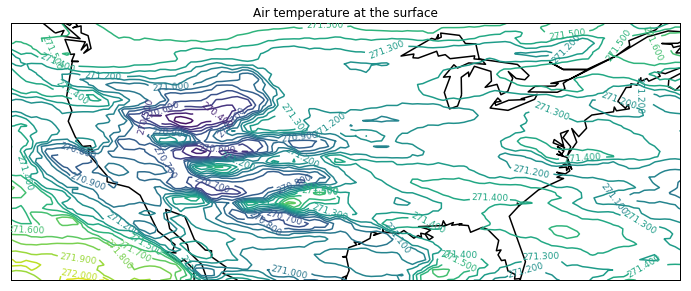

In [24]:
# read subset of air temperature
print('Reading T (subset)...', sys.stdout.flush())
T = rootgrp.variables['t'][11771,:,229:280,99:230]
print('done.')
sys.stdout.flush()
#
print('T.shape:', T.shape)
# 
# max/min
print('max(T): %.4f' % np.max(T))
print('min(T): %.4f' % np.min(T))
# 
# set up cylindrical map
#
fg = plt.figure(figsize=(12,10))
ax1 = plt.subplot('111')

m = Basemap(
    projection='cyl',
    llcrnrlat=25, urcrnrlat=50,
    llcrnrlon=-130, urcrnrlon=-65,
    resolution='c',
    ax=ax1
    )
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary()
# 
# plot contour
level = 71 # surface
X = np.arange(-130.0, -64.99, .5) # -65 is the last element
Y = np.arange(25.0, 50.01, .5) # 50 is the last element
#

#
cp = ax1.contour(X, Y, T[level,:,:], 20, zorder=2)
ax1.clabel(cp, inline=1, fontsize=9)
ax1.set_title('Air temperature at the surface')
#plt.show()

In [13]:
#nc4.Dataset('http://thredds.socib.es/thredds/dodsC/hf_radar/hf_radar_ibiza-scb_codarssproc001/L1/2016/dep0001_hf-radar-ibiza_scb-codarssproc001_L1_2016-02.nc')

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format DAP2):
    title: Data from instrument SCB-CODARSSPROC001 on platform HF Radar Ibiza
    institution: SOCIB (Sistema de Observación y predicción Costero de las Islas Baleares)
    netcdf_version: 3.0
    Conventions: CF-1.6
    abstract: Real-time surface current data in the Ibiza Channel from the installed HF radar.
    summary: Real-time surface current data in the Ibiza Channel from the installed HF radar.
    date_created: 2016-02-01T01:21:13+00:00
    date_update: 2016-03-11T14:21:35+00:00
    date_modified: 2016-03-11T14:21:35+00:00
    cdm_data_type: Grid
    CF%3afeatureType: grid
    featureType: grid
    data_mode: R
    processing_level: L1 - Derived variables and quality control procedures applied
    instrument_serial: EB560F37-F444-4F2A-AEC9-1018898EA990
    id: 112_270_2016-03-11T14:21:35+00:00
    platform_code: 112
    instrument_code: 270
    keywords_vocabulary: http://gcmd.nasa.go